In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
# Importing train and test dataset

train = pd.read_csv("F:/vinit.rege/Santander Customer Transaction Prediction/train.csv")
test = pd.read_csv("F:/vinit.rege/Santander Customer Transaction Prediction/test.csv")

In [3]:
# Finding null values in train dataset

null_columns=train.columns[train.isnull().any()]
train[null_columns].isnull().sum()

Series([], dtype: float64)

In [4]:
# Finding null values in test dataset

null_columns=test.columns[test.isnull().any()]
test[null_columns].isnull().sum()

Series([], dtype: float64)

So, we can say that there is no null values in whole train and test dataset.

In [5]:
# Remove constant columns (std = 0)

remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [6]:
# Remove duplicated columns
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [7]:
# Split data into train and test
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=48)
print(X_train.shape, X_test.shape, test.shape)

(60816, 306) (15204, 306) (75818, 306)


# Model Generation

In [8]:
# Feature selection
clf = ExtraTreesClassifier(random_state=48)
selector = clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


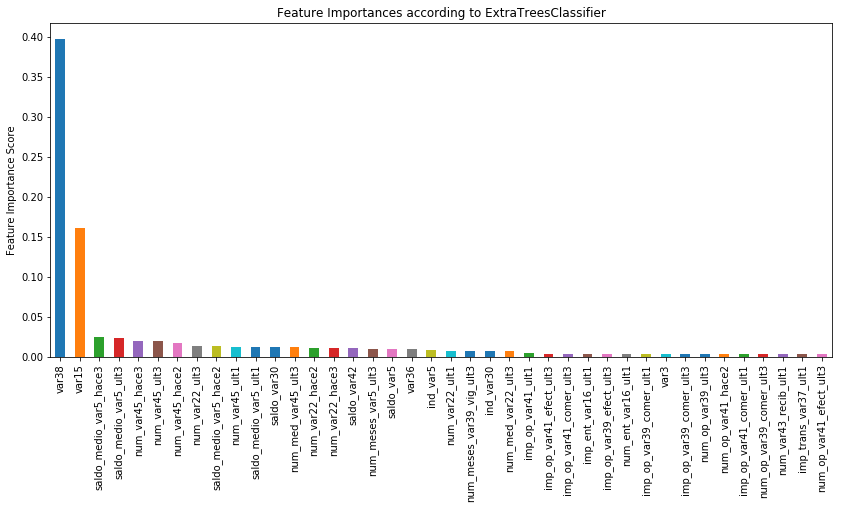

In [9]:
# Plot most important features (extracting Imp features)
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(14, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

In [10]:
# clf.feature_importances_ 

fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)

(60816, 41) (15204, 41) (75818, 41)


In [11]:
# Train Model, classifier from xgboost

m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, \
seed=48)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=110, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=48, silent=None, subsample=1, verbosity=1)

In [12]:
# Calculate the auc score

print("Roc AUC: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

Roc AUC:  0.8327714433334735


In [13]:
# Submission

probs = m2_xgb.predict_proba(test)
submission_XGB = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission_XGB.to_csv("F:/vinit.rege/Santander Customer Transaction Prediction/submission.csv", index=False)
